In [8]:
import numpy as np

from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.signal import triang
from scipy.stats import skewnorm

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

In [154]:
# 1.1

# Construct circulant Toeplitz matrix Tdx with dim Tdx = N, 
# discretization of dx^2 operator with periodix boundary conditions
def Toeplitz(N, dx, boundary='circulant'):
    T = 1/dx**2 * (np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1))
    if boundary == 'circulant':
        T[0, -1] = T[1, 0]
        T[-1,0] = T[0,1]
    
    return T


# Get sparse Toeplitz matrix, boundary conditions either 
# periodic (circulant, default) or homogenous Dirichlet
def sToeplitz(N, dx, boundary='circulant'):
    
    return csr_matrix(Toeplitz(N, dx, boundary))


# Take one explicit Euler step
def eulerstep(Tdx, uold, dt):
    
    return uold + dt*Tdx.dot(uold)


# Get array of matrices in Crank-Nicolson method
def get_CN_matrices(N, dx, dt, boundary='circulant'):
    
    return [csr_matrix(np.identity(N) - dt/2*Toeplitz(N, dx, boundary)), 
            csr_matrix(np.identity(N) + dt/2*Toeplitz(N, dx, boundary))]


# Take one Crank-Nicolson step
def TRstep(Tdx, uold, dt):

    return spsolve(Tdx[0], Tdx[1].dot(uold))


def solveDiffusion(N, M, x0, x_end, to, t_end, method, iv='triangle', boundary = 'homogenous dirichlet'):
    # Construct spatial and temporal grids
    dx = 1/(N+1)
    dt = 1/M
    courant = dt/dx**2
    
    print(f'courant = {dt/dx**2}')
    print(f'optimal = {2*(N+1)**2}')

    xx = np.linspace(x0, x_end, N+2)
    tt = np.linspace(t0, t_end, M+1)

    X, T = np.meshgrid(xx, tt, indexing='xy')

    # Inital conditions (homogenous Dirichlet)
    g = get_iv(iv, xx, N)


    # Create (empty) solution vector u and insert initial value g(x). 
    u = np.zeros([M+1, N+2]) # [N_rows, N_cols], N_rows~len(T)=M+1
    u[0] = g

    # Solve discretized ut = uxx on grid, n~t
    if method == 'Explicit Euler':
        Tdx = sToeplitz(N, dx, boundary)

        for n in range(M):
            u[n+1][1:-1] = eulerstep(Tdx, u[n][1:-1], dt)
            
    elif method == 'Crank-Nicolson':
        Tdx = get_CN_matrices(N, dx, dt, boundary)
        
        for n in range(M):
            u[n+1][1:-1] = TRstep(Tdx, u[n][1:-1], dt)            
    
    return u, X, T, courant


# Method for a few obtaining a few different intial values (functions)
def get_iv(iv, xx, N):
    if iv == 'Gaussian':
        return 1*np.exp(-100*(xx-1/2)**2)
    elif iv == 'skewed Gaussian':
        return skewnorm.pdf(xx, a=-2, loc=xx[-1]/2, scale=0.3)
    elif iv == 'Triangle':
        return 10*triang(N+1)
    elif iv == 'parabola':
        return -10*xx*(xx-1)
    
    return None
    
# Subplot label help-method
def get_label(i):
    if i == 0:
        return '(a)'
    if i == 1:
        return '(b)'
    if i == 2:
        return '(c)'
    if i == 3: 
        return '(d)'
    
    return 

courant = 2550.25
optimal = 20402
courant = 1020.1
optimal = 20402
courant = 102.00999999999999
optimal = 20402
courant = 0.010200999999999998
optimal = 20402


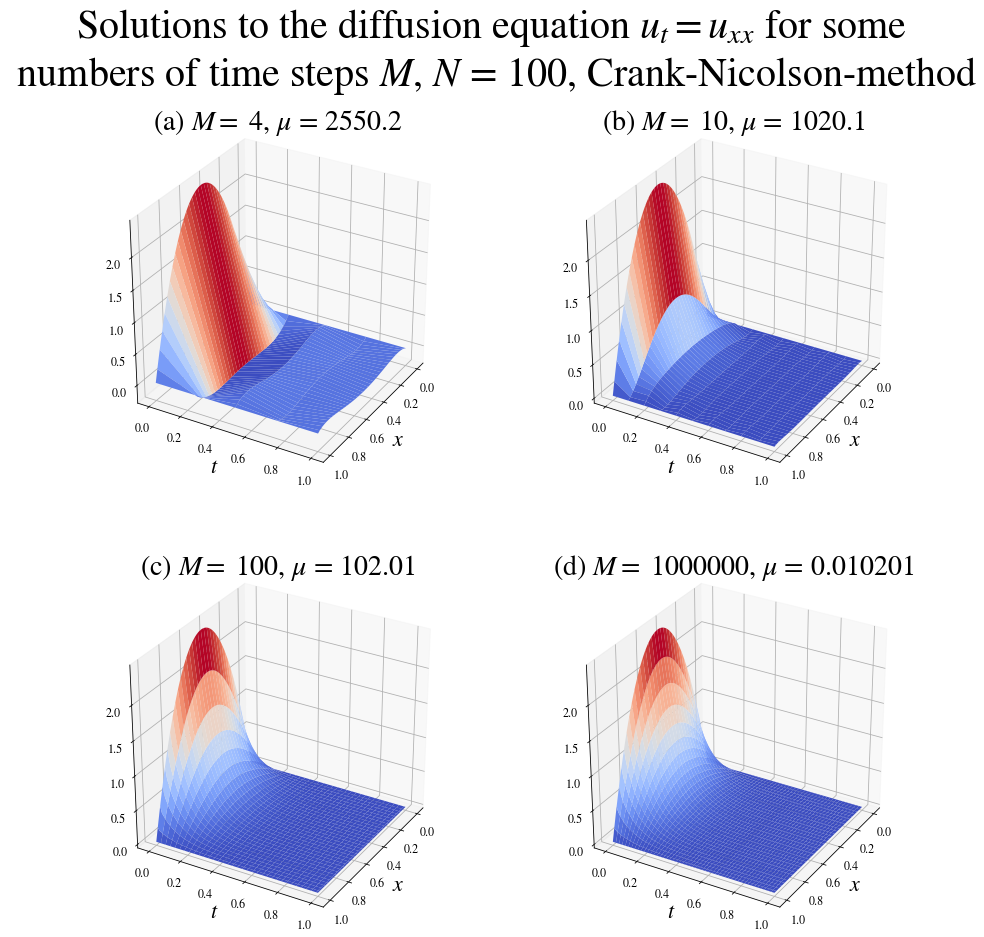

In [143]:
# 1.1 & 2

# Initialize constants
method = 'Crank-Nicolson'
iv = 'parabola'
x0 = 0 
x_end = 1
t0 = 0
t_end = 1
N = 100 # space
Ms = []

if method == 'Explicit Euler':
    Ms = [20410, 20390, 20380, 20378] # time
elif method == 'Crank-Nicolson':
    Ms = [4, 10, 100, 1000000]

# Prepare for plotting
fig = plt.figure(figsize=[15, 15])
fig.suptitle('Solutions to the diffusion equation $u_t = u_{xx}$ for some ' + 
             '\n numbers of time steps $M$, $N$ = 100,' + f' {method}-method', fontsize=40)

# Solve diffusion equation
for i in range(len(Ms)): 
    u, X, T, courant = solveDiffusion(N, Ms[i], x0, x_end, t0, t_end, method, iv)
    
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.plot_surface(X, T, u, cmap='coolwarm', linewidth=0)
    ax.set_title(get_label(i) + f' $M =$ {Ms[i]},' + r' $\mu$ = ' + f'{courant:.5}', fontsize=28, y = 1.025)
    ax.set_xlabel('$x$', fontsize=22)
    ax.set_ylabel('$t$', fontsize=22)
    if method == 'Crank-Nicolson':
        ax.view_init(30, 30)

In [142]:
# 2.

# Take one step with Lax-Wendroff method
def LaxWen(u, amu, N):
    A = np.diag((1-amu**2)*np.ones(N)) - np.diag(amu/2*(1-amu)*np.ones(N-1), 1) + np.diag(amu/2*(1+amu)*np.ones(N-1), -1)
    A[0, -1] = amu/2*(1+amu)
    A[-1, 0] = -amu/2*(1-amu) 
    
    u = csr_matrix(A).dot(u)

    return np.insert(u, len(u), u[0])
    
# Solve linear advection problem ut + a ux = 0 using Lax-Wendroff method
def solveLinAdv(N, M, a, x0, x_end, t0, t_end):
    dx = 1/N
    dt = 1/M
    
    amu = a*dt/dx
    
    # Create grids
    xx = np.linspace(x0, x_end, N+1)
    tt = np.linspace(t0, t_end, M+1)

    X, T = np.meshgrid(xx, tt, indexing='xy')

    # Insert initial value into solution vector
    g = np.exp(-100*(xx-1/2)**2)
    #g = 10*triang(N+1)
    
    u = np.zeros([M+1, N+1])
    u[0] = g

    # Solve the PDE: Take step, M times
    for n in range(M):
        u[n+1] = LaxWen(u[n][:-1], amu, N)
    
    return u, X, T, amu


# Return array of RMS-norms of u(t,.) for each t0<t<t_end
def get_RMSnorm(u, N):
    norm = np.zeros(u.shape[0])

    for i in range(u.shape[0]):
        norm[i] =  np.sqrt(1/(N+1) * np.sum([np.power(a, 2) for a in u[i][:-1]]))
    
    return norm


def get_suptitle(a, N, M):
    if a == -1:
        return 'Solution to the advection equation $u_t - u_x = 0$,' + 
                ' using \n the Lax-Wendroff method, $a\mu = $' + f'{amu:.4}, $N$ = {N}, $M$ = {M}'
    elif a == 1:
        return 'Solution to the advection equation $u_t + u_x = 0$, using \n the Lax-Wendroff method, $a\mu = $' + 
                f'{amu:.4}, $N$ = {N}, $M$ = {M}'
    elif a < 0:
        return 'Solution to the advection equation $u_t -$' + f'{-a}' + '$  u_x = 0$,' + 
                ' using \n the Lax-Wendroff method, $a\mu = $' + f'{amu:.4}, $N$ = {N}, $M$ = {M}'
    return 'Solution to the advection equation $u_t +$' + f'{a}' + '$  u_x = 0$,' + 
            ' using \n the Lax-Wendroff method, $a\mu = $' + f'{amu:.4}, $N$ = {N}, $M$ = {M}'

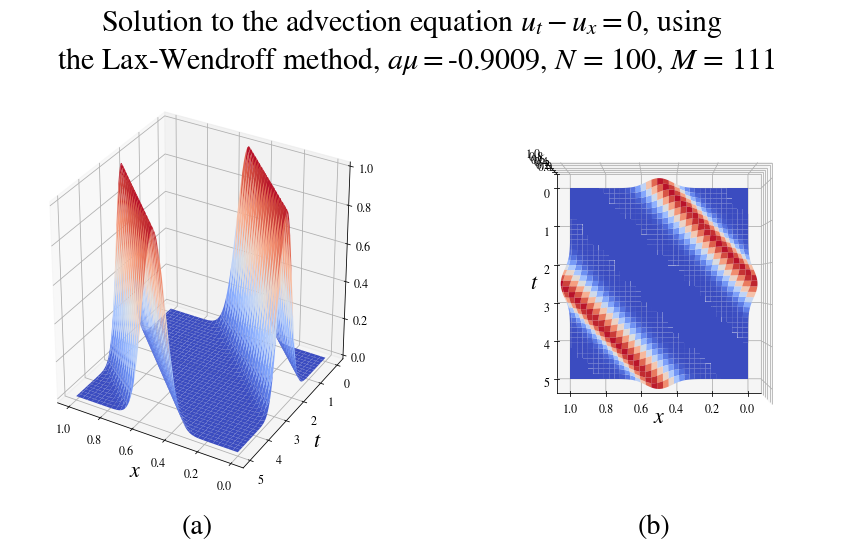

In [120]:
# 2.1

# Initialize constants
N = 100
M = 111
a = -1
x0 = 0
x_end = 1
t0 = 0
t_end = 5

# Solve PDE
u, X, T, amu = solveLinAdv(N, M, a, x0, x_end, t0, t_end)

# Plot
degree = [[30, 120], [90, 90]]

fig1 = plt.figure(figsize=[15, 7.5])
fig1.suptitle(get_suptitle(a, N, M), fontsize=30, y=1.025)

for i in range(2):
    ax = fig1.add_subplot(1, 2, i+1, projection='3d')
    ax.plot_surface(X, T, u, cmap='coolwarm', linewidth=0)
    ax.set_xlabel('$x$', fontsize=22)
    ax.set_ylabel('$t$', fontsize=22)
    ax.view_init(*degree[i])
    ax.set_title(get_label(i), fontsize=28, y=-0.125)



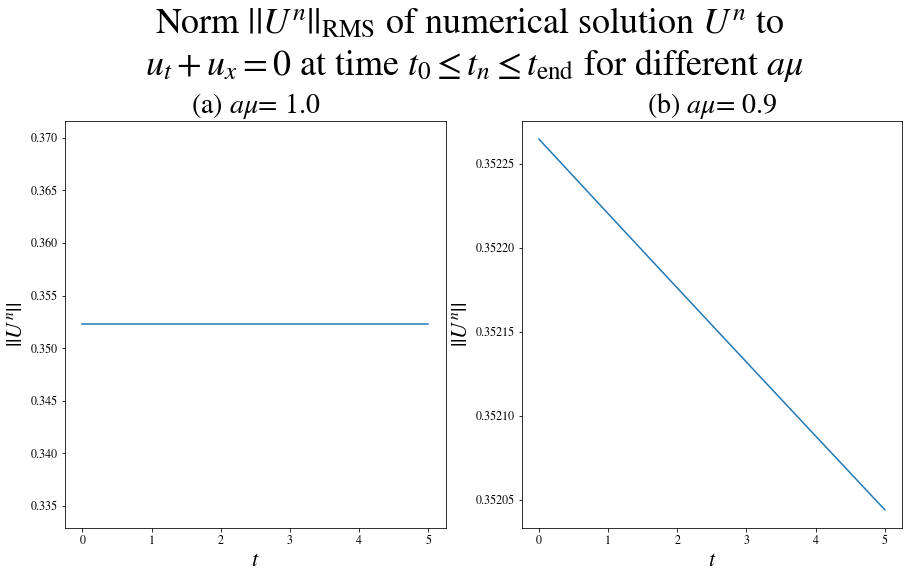

In [182]:
# 2.2

# Initialize constants
N = 100
Ms = [100, 111]
a = 1
x0 = 0
x_end = 1
t0 = 0
t_end = 5

# Prepare for plot
fig2 = plt.figure(figsize=[15, 7.5])
fig2.suptitle(r'Norm $\|\|U^n\|\|_{\mathrm{RMS}}$ ' + 
              'of numerical solution $U^n$ to \n $u_t + u_x = 0$ at time ' + 
              r'$t_0 \leq t_n \leq t_{\mathrm{end}}$ for different $a \mu$', fontsize=36, y=1.09)
    
# Solve PDE for different amu
for i in range(len(Ms)):
    u, _, _, amu = solveLinAdv(N, Ms[i], a, x0, x_end, t0, t_end)
    
    norm = get_RMSnorm(u, N)
   
    ax1 = fig2.add_subplot(1, 2, i+1)
    ax1.set_title(get_label(i) + r' $a \mu $= ' + f'{amu:.2}', fontsize=28)
    ax1.set_xlabel('$t$', fontsize=22)
    ax1.set_ylabel('$\|\|U^n\|\|$', fontsize=22)
    ax1.plot(np.linspace(t0, t_end, Ms[i]+1), norm)

In [82]:
# 3.

# Circulant discretization S of dx operator with periodic boundary conditions
def S(N, dx):
    s = 1/2/dx*(np.diag(-1*np.ones(N-1), -1) + np.diag(np.ones(N-1), 1))
    s[0, -1] = s[1, 0]
    s[-1,0] = s[0,1]
    
    return s


# Return sparse circulant S matrix, discretization of dx operator
def sS(N, dx):

    return csr_matrix(S(N, dx))


# Return (semidiscr.) spatial circulant matrix M ~ dxx - dx in convection-diffusion equation
def get_spatial_matrix(a, d, N, dx):
    
    return d*Toeplitz(N, dx) - a*S(N, dx)

# Matrices T0, T1 used in trapezoidal rule 
def get_trap_matrices(a, d, dt, dx, N):
    M = get_spatial_matrix(a, d, N, dx)
    
    return csr_matrix(np.identity(N) - dt/2*M), csr_matrix(np.identity(N) + dt/2*M)


# One step with trapezoidal rule for convection-diffusion equation; sparse matrices
def trap_step(uold, T0, T1):    
    unew = spsolve(T0, T1.dot(uold))
    
    return np.insert(unew, len(unew), unew[0])


# Solve convection-diffusion problem
def solve_convdif(a, d, N, M, x0, x_end, t0, t_end, iv = 'Gaussian'):
    dx = 1/N
    dt = 1/M
    
    Pe = np.abs(a/d)
    
    # Create grids
    xx = np.linspace(x0, x_end, N+1)
    tt = np.linspace(t0, t_end, M+1)

    X, T = np.meshgrid(xx, tt, indexing='xy')

    # Insert initial value(s) (function) into solution vector
    g = get_iv(iv, xx, N)
    
    u = np.zeros([M+1, N+1])
    u[0] = g
    
    # Solve convection-diffusion problem by iterating trapezoidal rule 
    T0, T1 = get_trap_matrices(a, d, dt, dx, N)
    
    for n in range(M):
        u[n+1] = trap_step(u[n][:-1], T0, T1)
    
    return u, X, T, Pe

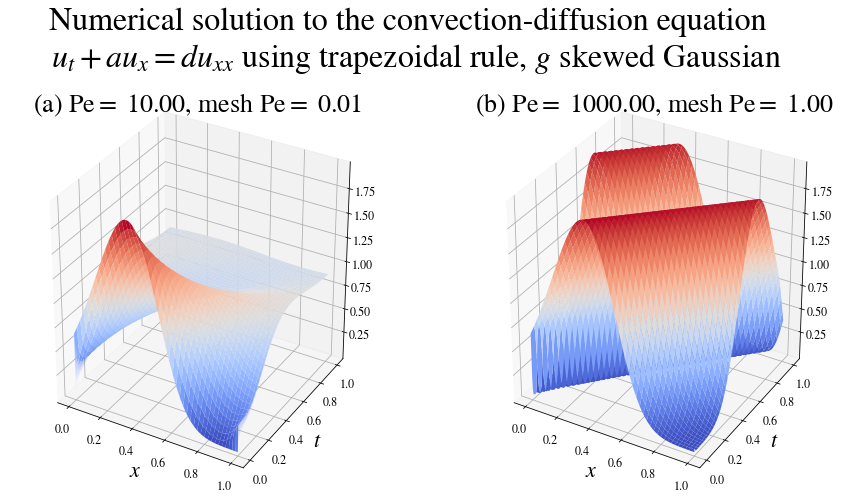

In [188]:
# 3.

# Initialize constants
a = 1
d = [0.1, a/1000]
N = 1000
M = 1000
x0 = 0
x_end = 1
t0 = 0
t_end = 1
iv = 'skewed Gaussian'

# Prepare plot
fig = plt.figure(figsize=[15, 7.5])
fig.suptitle('Numerical solution to the convection-diffusion equation \n $u_t + au_x = du_{xx}$ ' + 
             'using trapezoidal rule, $g$ ' + f'{iv}', fontsize=32, y=1.025)

# Solve covection-diffusion equation
for i in range(len(d)):
    u, X, T, Pe = solve_convdif(a, d[i], N, M, x0, x_end, t0, t_end, iv)

    # Plot
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    ax.plot_surface(X, T, u, cmap='coolwarm', linewidth=0)
    ax.set_title(get_label(i) + r' $\mathrm{Pe} =$ ' + f'{Pe:.2f},' + r' $\mathrm{mesh \ Pe} =$ ' + 
                 f'{Pe/N:.2f}', fontsize=26)
    ax.set_xlabel('$x$', fontsize=22)
    ax.set_ylabel('$t$', fontsize=22)

Text(0.5, 0, '$t$')

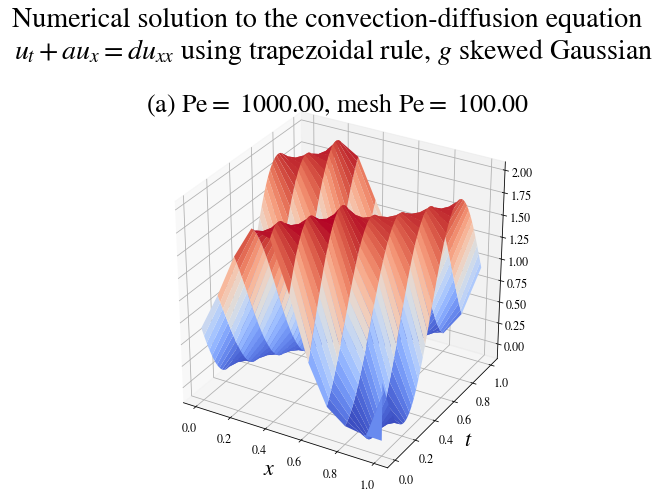

In [192]:
# Initialize constants
a = 1
d = a/1000
N = 10
M = 1000
x0 = 0
x_end = 1
t0 = 0
t_end = 1
iv = 'skewed Gaussian'

# Prepare plot
fig = plt.figure(figsize=[7.5, 7.5])
fig.suptitle('Numerical solution to the convection-diffusion equation \n $u_t + au_x = du_{xx}$ ' + 
             'using trapezoidal rule, $g$ ' + f'{iv}', fontsize=28, y=1.025)

# Solve covection-diffusion equation

u, X, T, Pe = solve_convdif(a, d, N, M, x0, x_end, t0, t_end, iv)

# Plot
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, T, u, cmap='coolwarm', linewidth=0)
ax.set_title(get_label(0) + r' $\mathrm{Pe} =$ ' + f'{Pe:.2f},' + r' $\mathrm{mesh \ Pe} =$ ' + 
             f'{Pe/N:.2f}', fontsize=26)
ax.set_xlabel('$x$', fontsize=22)
ax.set_ylabel('$t$', fontsize=22)

In [88]:
# 4

# Step of invisid part of viscous Burgers' equation, using sparse matrices
def LW(uold, dt, dx, N):
    
    return uold - dt*uold*sS(N, dx).dot(uold) + dt**2/2*(2*uold*np.square(sS(N, dx).dot(uold)) + 
                                                         np.square(uold)*sToeplitz(N, dx).dot(uold))


# Return left hand side sparse matrix B in trapezoidal rule in 
# viscous Burgers' equation  Bu=LW(uold) + d*dt/2*Toeplitz uold
def get_trap_Burgers_smatrix(d, dt, dx, N):
    
    return csr_matrix(np.identity(N) - d*dt/2*Toeplitz(N, dx))


# Take one trapezoidal step in viscous Burgers' equation,
# T LHS sparse matrix of trapezoidal rule,  
def trap_Burgers_step(B, uold, d, dt, dx, N):
    unew = spsolve(B, LW(uold, dt, dx, N) + d*dt/2*sToeplitz(N, dx).dot(uold))

    return np.insert(unew, len(unew), unew[0]) 


# Solve viscous Burgers' equation with periodic boundary condititons, initial value give by kw iv
def solve_visBurgers(d, N, M, x0, x_end, t0, t_end, iv):
    dx = 1/N
    dt = 1/M
    
    # Create grids
    xx = np.linspace(x0, x_end, N+1)
    tt = np.linspace(t0, t_end, M+1)

    X, T = np.meshgrid(xx, tt, indexing='xy')

    # Insert initial value(s) (function) into solution vector
    g = get_iv(iv, xx, N)
    
    u = np.zeros([M+1, N+1])
    u[0] = g
    
    # Get LHS matrix B of trapezoidal rule, used when iterating for soluions over time 
    B = get_trap_Burgers_smatrix(d, dt, dx, N)
    
    # Solve over time using trapezoidal rule
    for n in range(M):
        u[n+1] = trap_Burgers_step(B, u[n][:-1], d, dt, dx, N)
        
    return u, X, T    

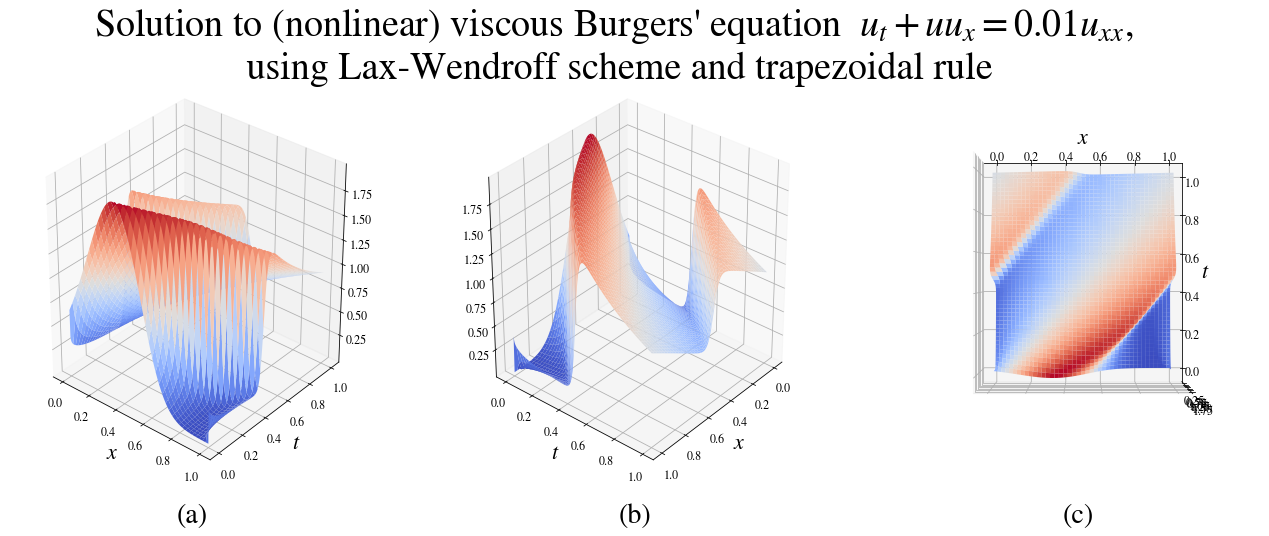

In [148]:
# 4.

# Initialize constants
d = 0.01
N = 300
M = 1000
x0 = 0
x_end = 1
t0 = 0
t_end = 1
iv = 'skewed Gaussian'

# Solve equation
u, X, T = solve_visBurgers(d, N, M, x0, x_end, t0, t_end, iv)

# Plot
degree = [[30, -50], [30, 40], [90, -90]]

fig1 = plt.figure(figsize=[22.5, 7.5])
fig1.suptitle('Solution to (nonlinear) viscous Burgers\' equation ' + 
              f' $u_t + uu_x = {d if d != 1 else str( )}$' + 
              '$u_{xx}$, \n using Lax-Wendroff scheme and trapezoidal rule', fontsize=38, y=1.005)

for i in range(3):
    ax = fig1.add_subplot(1, 3, i+1, projection='3d')
    ax.plot_surface(X, T, u, cmap='coolwarm', linewidth=0)
    ax.set_title(get_label(i), fontsize=28, y=-0.125)
    ax.set_xlabel('$x$', fontsize=22)
    ax.set_ylabel('$t$', fontsize=22)
    ax.view_init(*degree[i])